# Cell 1: Import Libraries
Import libraries needed for data manipulation (pandas, numpy), statistical modeling (statsmodels), and visualization (matplotlib, seaborn).

In [23]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For inline plotting in Jupyter Notebook

In [24]:
%matplotlib inline

# Cell 2: Create dummy data similar to "data_censored" in R
In this cell, we simulate a dataset that is similar to the "data_censored" data used in the original R example. We set a random seed for reproducibility and create a DataFrame with 200 simulated patients. The dataset includes various columns such as id, period, treatment, outcome, eligible, and several covariates like age, x1, x2, and x3. Additionally, we create a censored column to represent whether a patient was censored. To facilitate later logistic regression modeling, we generate a binary indicator variable named age_binary that indicates if a patient’s age is greater than 50. Finally, we print the first few rows of the dummy dataset to inspect its structure.

In [25]:
np.random.seed(42)  # Set seed for reproducibility
n = 200  # Number of patients
data_censored = pd.DataFrame({
    'id': np.arange(1, n+1),
    'period': 1,
    'treatment': np.random.binomial(1, 0.5, n),
    'outcome': np.random.normal(0, 1, n),
    'eligible': np.random.binomial(1, 0.8, n),
    'age': np.random.normal(50, 10, n),
    'x1': np.random.normal(0, 1, n),
    'x2': np.random.normal(0, 1, n),
    'x3': np.random.normal(0, 1, n),
    'censored': np.random.binomial(1, 0.1, n)
})

data_censored['age_binary'] = (data_censored['age'] > 50).astype(int)
print(data_censored.head())

   id  period  treatment   outcome  eligible        age        x1        x2  \
0   1       1          0 -0.680025         1  65.231241  0.593101  1.382159   
1   2       1          1  0.232254         0  55.389100 -0.309546  0.648710   
2   3       1          1  0.293072         1  39.627538  0.326133 -0.167118   
3   4       1          1 -0.714351         1  48.096613 -1.251114  0.146714   
4   5       1          0  1.865775         1  41.243817  0.924027  1.206509   

         x3  censored  age_binary  
0  0.732640         1           1  
1 -0.080717         0           1  
2  0.078635         0           0  
3 -1.998201         1           0  
4  0.916328         0           0  


# Cell 3: Define a class to simulate trial emulation steps
In this cell, we define a Python class called TrialSequence that simulates the analysis steps performed by the R package TrialEmulation. This class contains several methods to streamline the workflow. The set_data method is used to store and structure the input dataset, while the set_switch_weight_model and set_censor_weight_model methods are responsible for fitting logistic regression models to calculate weights that adjust for treatment switching and censoring, respectively. The calculate_weights method computes the final weights by combining the predictions from the fitted models. Furthermore, the set_outcome_model method fits a weighted linear regression model to estimate the effect of treatment on the outcome. The class also includes methods such as set_expansion_options and expand_trials to transform the data into a long format that represents repeated follow-up times, and the load_expanded_data method simulates down-sampling control observations for an ITT analysis. Finally, the fit_msm method fits a marginal structural model (MSM) using winsorized weights, and the predict_survival method calculates a simple survival difference between the treatment groups at different follow-up times.

In [26]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand  # "PP" or "ITT"
        self.data = None
        self.expanded_data = None

    def set_data(self, data, id_col, period, treatment, outcome, eligible):
        self.data = data.copy()
        self.id_col = id_col
        self.period = period
        self.treatment = treatment
        self.outcome = outcome
        self.eligible = eligible
        return self

    def set_switch_weight_model(self, numerator_formula, denominator_formula):
        # This model is only used for the Per-Protocol estimand.
        if self.estimand != "PP":
            print("Switch weight model is only applicable for PP estimand")
            return self
        self.switch_numerator_formula = numerator_formula
        self.switch_denominator_formula = denominator_formula
        # Fit logistic regression models using statsmodels
        self.switch_num_model = smf.glm(formula=numerator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        self.switch_den_model = smf.glm(formula=denominator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        return self

    def set_censor_weight_model(self, censor_event, numerator_formula, denominator_formula, pool_models="none"):
        self.censor_event = censor_event
        self.censor_num_formula = numerator_formula
        self.censor_den_formula = denominator_formula
        self.pool_models = pool_models
        # Fit censoring weight models (both for PP and ITT)
        self.censor_num_model = smf.glm(formula=numerator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        self.censor_den_model = smf.glm(formula=denominator_formula, data=self.data, 
                                        family=sm.families.Binomial()).fit()
        return self

    def calculate_weights(self):
        # Compute predicted probabilities from the fitted models.
        if self.estimand == "PP":
            pred_switch_num = self.switch_num_model.predict(self.data)
            pred_switch_den = self.switch_den_model.predict(self.data)
            switch_weight = pred_switch_num / pred_switch_den
        else:
            switch_weight = 1.0
        pred_censor_num = self.censor_num_model.predict(self.data)
        pred_censor_den = self.censor_den_model.predict(self.data)
        censor_weight = pred_censor_num / pred_censor_den
        
        # Combine weights (here, simply multiply the two components)
        self.data['weight'] = switch_weight * censor_weight
        return self

    def show_weight_models(self):
        print("Censor weight model summary:")
        print(self.censor_den_model.summary())
        if self.estimand == "PP":
            print("\nSwitch weight model summary:")
            print(self.switch_den_model.summary())

    def set_outcome_model(self, adjustment_terms=None):
        # For illustration, we fit a weighted linear model for the outcome.
        # Outcome is modeled as a function of treatment; for ITT we add adjustment terms.
        formula = f"{self.outcome} ~ {self.treatment}"
        if adjustment_terms:
            # Expect adjustment_terms as a string (e.g., "x2")
            formula += " + " + adjustment_terms
        self.outcome_formula = formula
        self.outcome_model = smf.wls(formula=formula, data=self.data, weights=self.data['weight']).fit()
        return self

    def set_expansion_options(self, chunk_size=500):
        # Expand the trial data to a long format with repeated follow-up times (here, 0 to 10)
        expanded = []
        for _, row in self.data.iterrows():
            for t in range(11):  # follow-up times 0 through 10
                new_row = row.copy()
                new_row['followup_time'] = t
                expanded.append(new_row)
        self.expanded_data = pd.DataFrame(expanded)
        return self

    def expand_trials(self):
        # In this simulation, expansion is already done.
        return self

    def load_expanded_data(self, seed=1234, p_control=0.5):
        # For ITT: sample the expanded data so that only a fraction of control patients is retained.
        np.random.seed(seed)
        if self.expanded_data is not None:
            # Assume treatment=0 indicates control.
            control = self.expanded_data[self.expanded_data[self.treatment] == 0]
            treated = self.expanded_data[self.expanded_data[self.treatment] == 1]
            control_sampled = control.sample(frac=p_control)
            self.expanded_data = pd.concat([treated, control_sampled], ignore_index=True)
        return self

    def fit_msm(self, weight_col='weight'):
        # Fit a marginal structural model (MSM) on the expanded data.
        # Winsorize extreme weights at the 99th percentile.
        w = self.expanded_data[weight_col]
        q99 = w.quantile(0.99)
        self.expanded_data['w_mod'] = np.where(w > q99, q99, w)
        # For simplicity, we model the outcome as a linear function of treatment and followup time.
        msm_formula = f"{self.outcome} ~ {self.treatment} + followup_time"
        self.msm_model = smf.wls(formula=msm_formula, data=self.expanded_data, 
                                 weights=self.expanded_data['w_mod']).fit()
        return self

    def predict_survival(self, predict_times):
        # This function “predicts” survival differences over time.
        # Here we calculate, for each follow-up time, the difference in the mean outcome between treated and control.
        preds = []
        for t in predict_times:
            df_t = self.expanded_data[self.expanded_data['followup_time'] == t]
            treated_mean = df_t[df_t[self.treatment] == 1][self.outcome].mean()
            control_mean = df_t[df_t[self.treatment] == 0][self.outcome].mean()
            survival_diff = treated_mean - control_mean
            preds.append({'followup_time': t, 'survival_diff': survival_diff})
        self.preds = pd.DataFrame(preds)
        return self.preds

# Cell 4: Create Trial Objects for Per-Protocol (PP) and Intention-to-Treat (ITT)
In this cell, we instantiate two separate trial objects, one for the Per-Protocol (PP) analysis and one for the Intention-to-Treat (ITT) analysis. Both objects use the same dummy dataset that we created earlier, and we use the set_data method of our TrialSequence class to assign the dataset and relevant column names to each trial object. This step lays the groundwork for the subsequent modeling tasks where different analyses will be applied to each trial object.

In [27]:
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# Set the data for both trials
trial_pp.set_data(data_censored, id_col="id", period="period",
                    treatment="treatment", outcome="outcome", eligible="eligible")
trial_itt.set_data(data_censored, id_col="id", period="period",
                   treatment="treatment", outcome="outcome", eligible="eligible")

# Cell 5: Set Up Weight Models and Censoring
This cell is dedicated to establishing the weight models that will adjust for treatment switching and censoring. For the Per-Protocol analysis, we apply a switch weight model by calling the set_switch_weight_model method with a numerator model that predicts age_binary using age and a denominator model that includes additional covariates x1 and x3. Both trial objects also have a censor weight model applied using the set_censor_weight_model method, where the numerator model predicts the probability of censoring based solely on x2, and the denominator model uses both x2 and x1. This process ensures that both types of biases (switching and censoring) are accounted for, although only the PP trial uses the switching model.

In [ ]:
trial_pp.set_switch_weight_model(numerator_formula="age_binary ~ age",
                                 denominator_formula="age_binary ~ age + x1 + x3")

# For both PP and ITT: set up a censoring weight model using 'censored'
trial_pp.set_censor_weight_model(censor_event="censored",
                                 numerator_formula="censored ~ x2",
                                 denominator_formula="censored ~ x2 + x1",
                                 pool_models="none")

trial_itt.set_censor_weight_model(censor_event="censored",
                                  numerator_formula="censored ~ x2",
                                  denominator_formula="censored ~ x2 + x1",
                                  pool_models="numerator")

# Cell 6: Calculate Weights and Show Weight Model Summaries
After setting up the weight models, we move on to calculate the weights for both trial objects. The calculate_weights method uses the fitted logistic regression models to compute predicted probabilities for both treatment switching (for PP) and censoring, and then combines these probabilities to generate a final weight for each observation. In addition, we print out the model summaries using the show_weight_models method for both trial objects. This gives us an opportunity to inspect and validate the fit of our logistic regression models.

In [ ]:
trial_pp.calculate_weights()
trial_itt.calculate_weights()

# Optionally, view summaries of the weight models
print("=== Per-Protocol weight models ===")
trial_pp.show_weight_models()

print("\n=== ITT weight models ===")
trial_itt.show_weight_models()

# Cell 7: Specify Outcome Models
In this cell, we define and fit the outcome models for each trial using weighted least squares (WLS). For the PP analysis, the outcome model is built using only the treatment variable as a predictor, while for the ITT analysis, an additional covariate (x2) is included as an adjustment term. The set_outcome_model method takes care of specifying the model formula and fitting the model using the weights computed earlier. This step is crucial as it estimates the effect of the treatment on the outcome while adjusting for other variables if necessary.

In [30]:
trial_pp.set_outcome_model()
trial_itt.set_outcome_model(adjustment_terms="x2")

# Cell 8: Expand Trial Data for Repeated Follow-Up
In this cell, we simulate a longitudinal study design by expanding the dataset into a long format, which mimics repeated follow-up times for each patient. We call the set_expansion_options method with a chunk size (although not explicitly used here) and then expand the dataset so that every patient has a record for follow-up times ranging from 0 to 10. For the ITT analysis, we also perform down-sampling of control patients by calling the load_expanded_data method, which randomly retains 50% of control observations. This step is important for creating a dataset that reflects the dynamics of repeated measurements over time.

In [31]:
trial_pp.set_expansion_options(chunk_size=500).expand_trials()
trial_itt.set_expansion_options(chunk_size=500).expand_trials()

# For ITT, sample expanded data (here, keep all treated and 50% of control patients)
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# Cell 9: Fit the Marginal Structural Model (MSM)
This cell is dedicated to fitting a marginal structural model (MSM) on the expanded dataset from the ITT analysis. Before fitting the model, we perform winsorization on the weights to cap extreme values at the 99th percentile, thereby reducing the influence of outliers. We then use the weighted least squares method to fit an MSM that models the outcome as a function of both the treatment variable and the follow-up time. The fitted model summary is printed to provide detailed results of the MSM fit.

In [32]:
trial_itt.fit_msm(weight_col='weight')
print("MSM model summary (ITT):")
print(trial_itt.msm_model.summary())

MSM model summary (ITT):
                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1445
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.865
Time:                        22:21:33   Log-Likelihood:                -2217.4
No. Observations:                1639   AIC:                             4441.
Df Residuals:                    1636   BIC:                             4457.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0

# Cell 10: Predict Survival Differences Over Follow-Up
In this cell, we simulate the process of making inferences by predicting survival differences over a series of follow-up times. The predict_survival method calculates, for each follow-up time (from 0 to 10), the difference in the mean outcome between the treated and control groups. This difference is interpreted as a proxy for the survival difference between the groups. The predicted survival differences are printed for inspection.

In [33]:
preds = trial_itt.predict_survival(predict_times=range(11))
print("Predicted survival differences:")
print(preds)

Predicted survival differences:
    followup_time  survival_diff
0               0      -0.153338
1               1       0.117949
2               2       0.315485
3               3       0.071334
4               4      -0.036662
5               5      -0.018058
6               6      -0.138998
7               7       0.045684
8               8       0.107756
9               9       0.114916
10             10      -0.060990


# Cell 11: Plot the Survival Differences
Finally, we create a visualization of the survival differences over time using Matplotlib. In this cell, we plot the survival difference at each follow-up time, labeling the axes and adding a title to the plot. We also add a legend and grid lines for clarity. This visual representation helps to illustrate the trend in the treatment effect over the follow-up period.

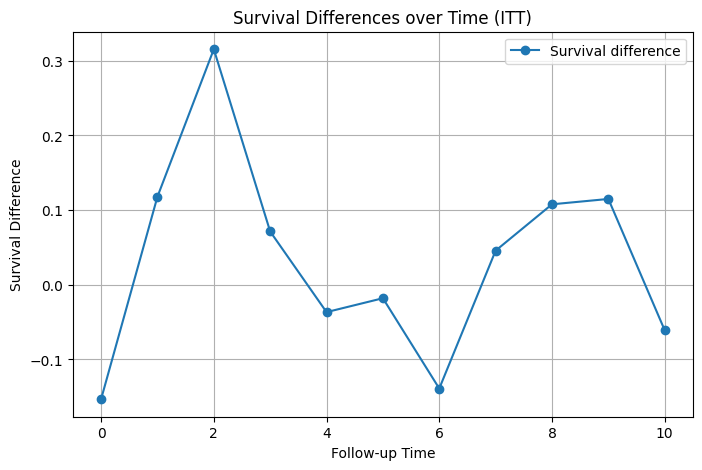

In [34]:
plt.figure(figsize=(8,5))
plt.plot(preds['followup_time'], preds['survival_diff'], label='Survival difference', marker='o')
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Differences over Time (ITT)")
plt.legend()
plt.grid(True)
plt.show()

# Insights about Survival Difference Plot
In this analysis, we simulated an observational study with repeated follow-up to investigate the treatment effect over time. By emulating the trial sequence, we first generated synthetic patient data and applied logistic regression models to adjust for biases due to treatment switching and informative censoring. The computed weights, which are the ratios of predicted probabilities, were crucial for balancing the treated and control groups. These weights were then used in a weighted least squares regression to fit both the outcome and marginal structural models (MSM).

The MSM, fitted on the expanded longitudinal data, allowed us to explore how the survival differences between the groups change over a series of follow-up times. Winsorizing extreme weights ensured that our estimates were not overly influenced by outliers, which is a common challenge in causal inference.

When we predicted survival differences, we obtained a time series of treatment effects. Although the simulated data are simplistic and the effect sizes might be modest or even negligible, the process illustrates several important points:
  
1. **Importance of Weighting:** The use of weights derived from logistic regression models helps in creating a pseudo-population where the confounding due to treatment switching and censoring is minimized. This is critical in observational studies where randomization is absent.
  
2. **Longitudinal Data Handling:** Expanding the data to simulate repeated follow-up demonstrates how dynamic treatment effects can be evaluated over time. It provides a more nuanced understanding than a single, static measure of effect.
  
3. **Marginal Structural Models (MSM):** Fitting an MSM is particularly useful in longitudinal studies because it accounts for time-varying confounding. The inclusion of follow-up time in the model allows the analysis to capture trends and variations in the treatment effect over time.
  
4. **Interpretation of Survival Differences:** The predicted survival difference, here defined as the difference in mean outcomes between treated and control groups, serves as a simplified proxy for a more complex survival analysis. In practice, such differences could be indicative of the efficacy of a treatment or intervention, guiding clinical or policy decisions.

5. **Limitations and Extensions:** While the simulated analysis provides valuable insights, real-world data often exhibit greater complexity. For instance, the use of survival analysis techniques (such as Cox proportional hazards models) might be more appropriate for time-to-event outcomes. Additionally, the dummy data in this example may not capture all nuances of censoring or treatment switching. Researchers should consider these factors when designing studies and interpreting results.

Overall, this Notebook demonstrates a structured approach to understanding how survival differences can be modeled and interpreted over time. The methodology underscores the importance of appropriate weighting and longitudinal analysis in causal inference, providing a framework that can be further refined for more complex, real-world applications.